In [2]:

import os
import sys
import subprocess
# sys.path.insert(1, f"{subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8')}/logistics/tools")
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER')}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools, endf_tools
import numpy as np
# import openmc
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
# from tools import image_to_thesis
# image_to_thesis.pull_from_thesis()


Running all MT
	Reaction 002


100%|██████████| 500/500 [00:25<00:00, 19.62it/s]


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

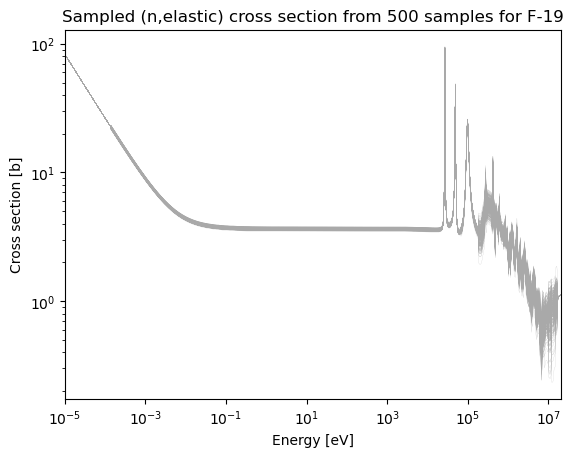

In [3]:
# VERSION = "v1"
VERSION = "v7"
# VERSION = "v3-TEST"
N_ITERATIONS = 500

for MT in [None]:
# for MT in [None, 2, 4, 16, 22, 28, 102, 103, 104, 105, 107]:
# for MT in [4]:
    
    if MT is None:
        print("Running all MT")
        res_folder = f"{VERSION}/ALL"
        MT_SUFFIX = ""
    else:
        print(f"Running MT{MT}")
        res_folder = f"{VERSION}/MT{MT}"
        MT_SUFFIX = f"-MT{MT}"
    
    os.system(f"rm -rf {res_folder}")
    os.makedirs(res_folder, exist_ok=True)

    for REACTION_INT in [2, 16, 22, 28, 51, 52, 53, 54, 91, 102, 103, 104, 105, 107]:
        # REACTION_INT = int(REACTION)
        REACTION = f"{REACTION_INT:03d}"
        print(f"\tReaction {REACTION}")

        plt.clf()
        plt.figure()

        if VERSION == "v1":
            sampled_h5_files_path = "/home/fne23_stjarnholm/nuclear_data/sandy_samples_v1/hdf5/F19"
            if MT is not None: raise NotImplementedError("No MT files exist for v1")
        elif VERSION == "v2":
            sampled_h5_files_path = "/home/fne23_stjarnholm/nuclear_data/sandy_samples_v2"
            if MT is not None: raise NotImplementedError("No MT files exist for v1")
        elif VERSION == "v3":
            sampled_h5_files_path = "/home/fne23_stjarnholm/nuclear_data/sandy_samples_v3"
        elif VERSION == "v3-TEST":
            sampled_h5_files_path = "/home/fne23_stjarnholm/nuclear_data/sandy_samples_v3-TEST"
        elif VERSION == "v7":
            sampled_h5_files_path = "/home/fne23_stjarnholm/nuclear_data/sandy_samples_v7"
        else:
            raise ValueError(f"Unknown version {VERSION}")

        if MT is not None:
            sampled_h5_files_path = f"{sampled_h5_files_path}-MT{MT}"

        fig = plt.figure()
        ax = fig.gca()

        TEMPERATURE = 900 # K

        x_logspace = np.logspace(np.log(1e-5), np.log(2e7), 2001) # 2000 bins between 1e-5 eV and 2e7 eV

        df = pd.DataFrame(columns=["energy", "xs"])

        energy_min = 2e7 # To be changed in each iteration
        
        # for i in tqdm(range(N_ITERATIONS)):
        for i in tqdm(range(N_ITERATIONS)):
            h5_filename = f"{sampled_h5_files_path}/F19-{i+1}.h5"

            h5file = h5py.File(h5_filename, 'r')
            energy_group = h5file[f'F19/energy/{TEMPERATURE}K']
            reactions_group = h5file[f'F19/reactions']
            # for name, obj in sorted(list(main_group.items()))[:10]:
            #     if 'reaction_' in name:
            #         print('{}, {}'.format(name, obj.attrs['label'].decode()))
            # print(min(energy_group), max(energy_group))
            

            n_elastic_xs_group = reactions_group[f'reaction_{REACTION}/{TEMPERATURE}K/xs']
            # print(list(n_elastic_group.values()))

            # Extract the cross section and energy data
            xs = n_elastic_xs_group[:]
            if len(xs) != len(energy_group[:]):
                energy = energy_group[-len(xs):]
            else:
                energy = energy_group[:]

            energy_min = min(energy_min, min(energy))        
    
            # print(energy.shape)
            # print(xs.shape)

            # Interpolate the cross section to the desired energy grid
            xs = np.interp(x_logspace, energy, xs)
            energy = x_logspace

            df = pd.concat([df, pd.DataFrame({"energy": energy, "xs": xs})], ignore_index=True)

            # F19_reconstructed = openmc.data.IncidentNeutron.from_hdf5(h5_filename)

            # Plot the sampled cross section
            # ax.loglog(energy, xs, label="Sampled")
            ax.loglog(energy, xs, label="Sampled", color="darkgrey", linewidth=0.1)

        ax.set_xlabel("Energy [eV]")
        ax.set_ylabel("Cross section [b]")
        ax.set_title(f"Sampled {endf_tools.MT_to_label(REACTION_INT, short=True)} cross section from {N_ITERATIONS} samples for F-19")
        ax.set_xlim(energy_min, 2e7)

        plt.savefig(f"{res_folder}/sampled_cross_section_plot_{VERSION}_{REACTION}{MT_SUFFIX}.png", dpi=300)
            
        plt.clf()
        plt.figure()
        ax = plt.gca()

        sns.lineplot(data=df, x="energy", y="xs", errorbar=('pi', 100), linewidth=0, label='_nolegend_')
        sns.lineplot(data=df, x="energy", y="xs", errorbar=('pi', 50), linewidth=0, label="_nolegend_")
        sns.lineplot(data=df, x="energy", y="xs", errorbar=None, linewidth=0.5, label="")
        plt.xscale("log")
        plt.yscale("log")

        ax.set_xlabel("Energy [eV]")
        ax.set_ylabel("Cross section [b]")
        ax.set_title(f"Sampled {endf_tools.MT_to_label(REACTION_INT, short=True)} cross section from {N_ITERATIONS} samples for F-19")
        ax.set_xlim(energy_min, 2e7)
        # plt.legend(['Mean', '50 % percentile interval', '90 % percentile interval', '100 % percentile interval'])
        plt.legend(['100 % percentile interval', '50 % percentile interval', 'Mean'])
        plt.tight_layout()

        plt.savefig(f"{res_folder}/errorbands_sampled_cross_section_plot_{VERSION}_{REACTION}{MT_SUFFIX}.pdf")

        plt.close('all')